# Preparing

In [437]:
# !nvidia-smi

## Install library

In [438]:
# !pip install --quiet pytorch-lightning==1.2.5
# !pip install --quiet tqdm==4.59.0

## Import libraries

In [439]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc, rcParams
import math

import pandas as pd
import numpy as np
import tqdm
print(tqdm.__version__)
from tqdm.notebook import tqdm
import pytorch_lightning as pl
print(pl.__version__)
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import autograd, nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

4.61.2
1.2.5


In [440]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALLETE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALLETE))

rcParams['figure.figsize'] = 12, 8

tqdm.pandas()

In [441]:
pl.seed_everything(42)

Global seed set to 42


42

# Data

## Loading watch data

In [442]:
path = "Datasets\Price_chart_Tang\Rolex 126334\Combine_all.csv"
path = 'Datasets\Price_chart_Game\Rolex\Rolex 126334\price.csv'
# path = 'Datasets\Price_chart_Game\Audemars Piguet\Audemars Piguet 15400OR\price.csv'
watch = pd.read_csv(path)
watch['Date'] = pd.to_datetime(watch['Date'], dayfirst=True)
watch['Price'] = pd.to_numeric(watch['Price'])
watch.head()

,Date,Price
0,2019-03-08,8775
1,2019-03-10,8852
2,2019-03-14,8852
3,2019-03-17,8615
4,2019-03-20,8579


In [443]:
watch = watch.resample('D', on='Date', convention='s').mean()
watch['Date'] = watch.index
watch.reset_index(drop=True, inplace=True)

watch.fillna(method='ffill', inplace=True)

print(watch.shape)
watch.head()

(1095, 2)


,Price,Date
0,8775.0,2019-03-08
1,8775.0,2019-03-09
2,8852.0,2019-03-10
3,8852.0,2019-03-11
4,8852.0,2019-03-12


In [444]:
watch["Prev_Price"] = watch.shift(1)["Price"]
watch.head()
print(type(watch))

<class 'pandas.core.frame.DataFrame'>


In [445]:
watch["Price_Change"] = watch.progress_apply(
    lambda row: 0 if np.isnan(row["Prev_Price"]) else row["Price"] - row["Prev_Price"],
    axis = 1
)
watch.head()

  0%|          | 0/1095 [00:00<?, ?it/s]

,Price,Date,Prev_Price,Price_Change
0,8775.0,2019-03-08,NaN,0.0
1,8775.0,2019-03-09,8775.0,0.0
2,8852.0,2019-03-10,8775.0,77.0
3,8852.0,2019-03-11,8852.0,0.0
4,8852.0,2019-03-12,8852.0,0.0


## Loading other data

In [446]:
gold = pd.read_csv("Datasets/Related_data/Gold_price.csv")
gold['Value'] = gold['Value'].str.replace(',','')
gold['Date'] = pd.to_datetime(gold['Date'], dayfirst=True)
gold['Value'] = pd.to_numeric(gold['Value'])
mask = (gold.Date >= watch.iloc[0]['Date']) & (gold.Date <= watch.iloc[-1]['Date'])
gold = gold.loc[mask]

gold = gold.resample('D', on='Date', convention='s').mean()
gold.fillna(method='ffill', inplace=True)

print(gold.shape)
gold.head()

(1093, 1)


,Value
Date,
2019-03-08,1296.8
2019-03-09,1296.8
2019-03-10,1296.8
2019-03-11,1292.8
2019-03-12,1297.1


## Create feature df

In [447]:
rows = []

for _, row in tqdm(watch.iterrows(), total=watch.shape[0]):
    row_data = dict(
        day_of_week = row.Date.dayofweek,
        day_of_month = row.Date.day,
        week_of_year = row.Date.week,
        month = row.Date.month,
        price_change = row.Price_Change,
        price = row.Price
    )
    rows.append(row_data)

features_df = pd.DataFrame(rows)

  0%|          | 0/1095 [00:00<?, ?it/s]

In [448]:
print(features_df.shape)
features_df.head()

(1095, 6)


,day_of_week,day_of_month,week_of_year,month,price_change,price
0,4,8,10,3,0.0,8775.0
1,5,9,10,3,0.0,8775.0
2,6,10,10,3,77.0,8852.0
3,0,11,11,3,0.0,8852.0
4,1,12,11,3,0.0,8852.0


## Set TRAIN_RATIO

In [449]:
TRAIN_RATIO = 0.8

train_size = int(len(features_df) * TRAIN_RATIO)
print(train_size)

876


In [450]:
train_df, test_df = features_df[:train_size], features_df[train_size:]
print(train_df.shape, test_df.shape)

(876, 6) (219, 6)


## Scaler

In [451]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scale = pd.read_csv('checkpoints/scale.csv', index_col=0)
scaler.min_, scaler.scale_ = list(scale.loc[:,'min']), list(scale.loc[:,'scale'])
# scaler = scaler.fit(train_df)

In [452]:
train_df = pd.DataFrame(
    scaler.transform(train_df),
    index=train_df.index,
    columns=train_df.columns
)

C:\Users\THETANG\anaconda3\envs\BIA_env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [453]:
test_df = pd.DataFrame(
    scaler.transform(test_df),
    # test_df,
    index=test_df.index,
    columns=test_df.columns
)

C:\Users\THETANG\anaconda3\envs\BIA_env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [454]:
test_df.head()

,day_of_week,day_of_month,week_of_year,month,price_change,price
876,0.666667,1.000000,0.137255,0.090909,0.389461,2.235786
877,1.000000,-1.000000,0.137255,0.272727,0.390623,2.238294
878,-1.000000,-0.933333,0.176471,0.272727,0.380752,2.226589
879,-0.666667,-0.866667,0.176471,0.272727,0.391203,2.229933
880,-0.333333,-0.800000,0.176471,0.272727,0.395848,2.239967


In [455]:
def create_sequences(input_data: pd.DataFrame, target_column, sequence_length, days_pred):

    sequences = []
    data_size = len(input_data)

    for i in tqdm(range(data_size - sequence_length - days_pred)):

        sequence = input_data[i:i+sequence_length]

        label_position = i + sequence_length + days_pred
        label = input_data.iloc[label_position][target_column]
        
        sequences.append((sequence, label))

    return sequences

## Set SEQUENCE_LENGTH and Created sequences

In [456]:
SEQUENCE_LENGTH = 30
DAYS_PREDICTION = 30

train_sequences = create_sequences(train_df, "price", SEQUENCE_LENGTH, DAYS_PREDICTION)
test_sequences = create_sequences(test_df, "price", SEQUENCE_LENGTH, DAYS_PREDICTION)

  0%|          | 0/816 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

In [457]:
print(f"Sequence shape: {train_sequences[0][0].shape}")
print(f"Train length: {len(train_sequences)}")
print(f"Test length: {len(test_sequences)}")
print(f"Test length: {train_sequences[0][1]}")
train_sequences[0][0].head()

Sequence shape: (30, 6)
Train length: 816
Test length: 159
Test length: 0.840719063544265


,day_of_week,day_of_month,week_of_year,month,price_change,price
0,0.333333,-0.533333,-0.647059,-0.636364,0.388881,0.665552
1,0.666667,-0.466667,-0.647059,-0.636364,0.388881,0.665552
2,1.000000,-0.400000,-0.647059,-0.636364,0.411235,0.697742
3,-1.000000,-0.333333,-0.607843,-0.636364,0.388881,0.697742
4,-0.666667,-0.266667,-0.607843,-0.636364,0.388881,0.697742


# Classes create

## Set device

In [458]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print("configured device:", device)

configured device: cuda


## TS_Dataset (Time series)

In [459]:
class TS_Dataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        
        sequence, label = self.sequences[idx]

        return dict(
            sequence = torch.Tensor(sequence.to_numpy()).to(device),
            label = torch.tensor(label).float().to(device)
        )

## Price Data Module

In [460]:
class PriceDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batch_size=8):
        super().__init__
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size
        
    def prepare_data(self):
        self._has_prepared_data = True

    def setup(self):
        self.train_dataset = TS_Dataset(self.train_sequences)
        self.test_dataset = TS_Dataset(self.test_sequences)
        self.prepare_data()
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=False
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=4,
            shuffle=False
        )
        
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=1,
            shuffle=False
        )

## Define BATCH_SIZE and N_EPOCHS

In [461]:
N_EPOCHS = 50
BATCH_SIZE = 64

data_module = PriceDataModule(train_sequences, test_sequences, batch_size=BATCH_SIZE)
data_module.setup()

In [462]:
train_dataset = TS_Dataset(train_sequences)

In [463]:
for item in train_dataset:
    print(item["sequence"].shape)
    print(item["label"].shape)
    print(item["label"])
    break

torch.Size([30, 6])
torch.Size([])
tensor(0.8407, device='cuda:0')


## Price Prediction Model

In [464]:
class PricePredictionModel(nn.Module):

    def __init__(self, n_features, n_hidden=128, n_layers=2):
        super().__init__()
        self.n_hidden = n_hidden
        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size =n_hidden,
            batch_first = True,
            num_layers = n_layers,
            dropout = 0.2
        )
        self.regressor = nn.Linear(n_hidden, 1)

    def forward(self, x):
        self.lstm.flatten_parameters()

        _, (hidden, _) = self.lstm(x)
        out = hidden[-1]

        return self.regressor(out)

## Price Predictor

In [465]:
class PricePredictor(pl.LightningModule):

    def __init__(self, n_features: int):
        super().__init__()
        self.model = PricePredictionModel(n_features).to(device)
        self.criterion = nn.MSELoss().to(device)

    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels.unsqueeze(dim=1))

        return loss, output
    
    def training_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss    

    def test_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return optim.Adagrad(self.parameters(), lr=1e-3)

In [466]:
model = PricePredictor(n_features=train_df.shape[1])

In [467]:
for item in data_module.train_dataloader():
    print(item["sequence"].shape)
    print(item["label"].shape)
    break

torch.Size([64, 30, 6])
torch.Size([64])


# Start Tensorboard

In [468]:
# %load_ext tensorboard
# %tensorboard --logdir ./lightning_logs

## checkpoint_callback setup

In [471]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

# logger = TensorBoardLogger("lightning_logs", name="watch-price")

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

trainer = pl.Trainer(
    # logger=logger,
    checkpoint_callback=checkpoint_callback,
    callbacks=[early_stopping_callback],
    max_epochs=N_EPOCHS,
    gpus=1,
    progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


## Fit

In [472]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                 | Params
---------------------------------------------------
0 | model     | PricePredictionModel | 201 K 
1 | criterion | MSELoss              | 0     
---------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 53/53 [00:00<00:00, 98.91it/s, loss=0.0935, v_num=0, val_loss=0.123, train_loss=0.0372]

Epoch 0, global step 12: val_loss reached 0.12333 (best 0.12333), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint-v9.ckpt" as top 1


Epoch 1: 100%|██████████| 53/53 [00:00<00:00, 84.08it/s, loss=0.0412, v_num=0, val_loss=0.0636, train_loss=0.00478]

Epoch 1, global step 25: val_loss reached 0.06356 (best 0.06356), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint-v9.ckpt" as top 1


Epoch 2: 100%|██████████| 53/53 [00:00<00:00, 79.97it/s, loss=0.0347, v_num=0, val_loss=0.0538, train_loss=0.00273]

Epoch 2, global step 38: val_loss reached 0.05376 (best 0.05376), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint-v9.ckpt" as top 1


Epoch 3: 100%|██████████| 53/53 [00:00<00:00, 89.34it/s, loss=0.0349, v_num=0, val_loss=0.0525, train_loss=0.00244]

Epoch 3, global step 51: val_loss reached 0.05249 (best 0.05249), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint-v9.ckpt" as top 1


Epoch 4: 100%|██████████| 53/53 [00:00<00:00, 87.31it/s, loss=0.0343, v_num=0, val_loss=0.0511, train_loss=0.00317]

Epoch 4, global step 64: val_loss reached 0.05114 (best 0.05114), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint-v9.ckpt" as top 1


Epoch 5: 100%|██████████| 53/53 [00:00<00:00, 97.49it/s, loss=0.0337, v_num=0, val_loss=0.0531, train_loss=0.00303]

Epoch 5, step 77: val_loss was not in top 1


Epoch 6: 100%|██████████| 53/53 [00:00<00:00, 100.38it/s, loss=0.0336, v_num=0, val_loss=0.0487, train_loss=0.0024]

Epoch 6, global step 90: val_loss reached 0.04875 (best 0.04875), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint-v9.ckpt" as top 1


Epoch 7: 100%|██████████| 53/53 [00:00<00:00, 118.65it/s, loss=0.0336, v_num=0, val_loss=0.0468, train_loss=0.00202]

Epoch 7, global step 103: val_loss reached 0.04679 (best 0.04679), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint-v9.ckpt" as top 1


Epoch 8: 100%|██████████| 53/53 [00:00<00:00, 119.64it/s, loss=0.0339, v_num=0, val_loss=0.0434, train_loss=0.00182]

Epoch 8, global step 116: val_loss reached 0.04338 (best 0.04338), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint-v9.ckpt" as top 1


Epoch 9: 100%|██████████| 53/53 [00:00<00:00, 126.71it/s, loss=0.034, v_num=0, val_loss=0.0427, train_loss=0.00192] 

Epoch 9, global step 129: val_loss reached 0.04271 (best 0.04271), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint-v9.ckpt" as top 1


Epoch 10: 100%|██████████| 53/53 [00:00<00:00, 129.06it/s, loss=0.0334, v_num=0, val_loss=0.0463, train_loss=0.00266]

Epoch 10, step 142: val_loss was not in top 1


Epoch 11: 100%|██████████| 53/53 [00:00<00:00, 120.38it/s, loss=0.0333, v_num=0, val_loss=0.0458, train_loss=0.0032] 

Epoch 11, step 155: val_loss was not in top 1


Epoch 12: 100%|██████████| 53/53 [00:00<00:00, 128.86it/s, loss=0.0334, v_num=0, val_loss=0.0446, train_loss=0.00255]

Epoch 12, step 168: val_loss was not in top 1


Epoch 13: 100%|██████████| 53/53 [00:00<00:00, 123.34it/s, loss=0.0334, v_num=0, val_loss=0.0436, train_loss=0.0026] 

Epoch 13, step 181: val_loss was not in top 1


Epoch 14: 100%|██████████| 53/53 [00:00<00:00, 122.29it/s, loss=0.0331, v_num=0, val_loss=0.0423, train_loss=0.00252]

Epoch 14, global step 194: val_loss reached 0.04231 (best 0.04231), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint-v9.ckpt" as top 1


Epoch 15: 100%|██████████| 53/53 [00:00<00:00, 126.21it/s, loss=0.033, v_num=0, val_loss=0.0435, train_loss=0.00239] 

Epoch 15, step 207: val_loss was not in top 1


Epoch 16: 100%|██████████| 53/53 [00:00<00:00, 119.92it/s, loss=0.0325, v_num=0, val_loss=0.0428, train_loss=0.00285]

Epoch 16, step 220: val_loss was not in top 1


Epoch 17: 100%|██████████| 53/53 [00:00<00:00, 113.01it/s, loss=0.0328, v_num=0, val_loss=0.0442, train_loss=0.00267]

Epoch 17, step 233: val_loss was not in top 1


Epoch 18: 100%|██████████| 53/53 [00:00<00:00, 106.20it/s, loss=0.0323, v_num=0, val_loss=0.0409, train_loss=0.00199]

Epoch 18, global step 246: val_loss reached 0.04094 (best 0.04094), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint-v9.ckpt" as top 1


Epoch 19: 100%|██████████| 53/53 [00:00<00:00, 117.10it/s, loss=0.0324, v_num=0, val_loss=0.0448, train_loss=0.00285]

Epoch 19, step 259: val_loss was not in top 1


Epoch 20: 100%|██████████| 53/53 [00:00<00:00, 120.34it/s, loss=0.0321, v_num=0, val_loss=0.0422, train_loss=0.00231]

Epoch 20, step 272: val_loss was not in top 1


Epoch 21: 100%|██████████| 53/53 [00:00<00:00, 116.16it/s, loss=0.0321, v_num=0, val_loss=0.041, train_loss=0.00227] 

Epoch 21, step 285: val_loss was not in top 1


Epoch 22: 100%|██████████| 53/53 [00:00<00:00, 123.18it/s, loss=0.0321, v_num=0, val_loss=0.0413, train_loss=0.00206]

Epoch 22, step 298: val_loss was not in top 1


Epoch 23: 100%|██████████| 53/53 [00:00<00:00, 116.26it/s, loss=0.0317, v_num=0, val_loss=0.0403, train_loss=0.00184]

Epoch 23, global step 311: val_loss reached 0.04030 (best 0.04030), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint-v9.ckpt" as top 1


Epoch 24: 100%|██████████| 53/53 [00:00<00:00, 108.97it/s, loss=0.0319, v_num=0, val_loss=0.0421, train_loss=0.00195]

Epoch 24, step 324: val_loss was not in top 1


Epoch 25: 100%|██████████| 53/53 [00:00<00:00, 119.23it/s, loss=0.0319, v_num=0, val_loss=0.0432, train_loss=0.0027] 

Epoch 25, step 337: val_loss was not in top 1


Epoch 26: 100%|██████████| 53/53 [00:00<00:00, 117.69it/s, loss=0.0317, v_num=0, val_loss=0.0424, train_loss=0.00252]

Epoch 26, step 350: val_loss was not in top 1


Epoch 27: 100%|██████████| 53/53 [00:00<00:00, 113.54it/s, loss=0.0317, v_num=0, val_loss=0.0415, train_loss=0.00203]

Epoch 27, step 363: val_loss was not in top 1


Epoch 28: 100%|██████████| 53/53 [00:00<00:00, 112.78it/s, loss=0.0319, v_num=0, val_loss=0.0425, train_loss=0.00231]

Epoch 28, step 376: val_loss was not in top 1


Epoch 28: 100%|██████████| 53/53 [00:00<00:00, 110.43it/s, loss=0.0319, v_num=0, val_loss=0.0425, train_loss=0.00231]


1

# Evaluation

## Load trained model

In [390]:
trained_model = PricePredictor.load_from_checkpoint(
    "checkpoints/best-checkpoint-v7.ckpt",
    n_features=train_df.shape[1]
)

In [391]:
trained_model.freeze()

## Predictions

In [392]:
test_dataset = TS_Dataset(test_sequences)

predictions = []
labels = []

for item in tqdm(test_dataset):
    sequence = item['sequence']
    label = item['label']

    _, output = trained_model(sequence.unsqueeze(dim=0))
    predictions.append(output.item())
    labels.append(label.item())

  0%|          | 0/159 [00:00<?, ?it/s]

In [393]:
len(predictions), len(test_df)-SEQUENCE_LENGTH

(159, 189)

In [394]:
print(predictions[:5])

[2.39607834815979, 2.396507740020752, 2.3966965675354004, 2.393723487854004, 2.392395257949829]


## Descale

In [395]:
def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

In [396]:
print(scaler.min_)

[-1.0, -1.0666666666666669, -1.03921568627451, -1.181818181818182, 0.3888808245028305, -3.0029264214046822]


In [397]:
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = scaler.min_[-1], scaler.scale_[-1]
print(scaler.min_[-1], scaler.scale_[-1])


predictions_descaled = descale(descaler, predictions)
labels_descaled = descale(descaler, labels)

print("Predictions: ", predictions_descaled[:5])
print("Labels: ", labels_descaled[:5])

-3.0029264214046822 0.0004180602006688
Predictions:  [12914.4194088  12915.44651413 12915.89818955 12908.78658295
 12905.60945702]
Labels:  [13008.99978447 13044.99979782 13056.00026131 13082.9998436
 13084.00014496]


## Plot graph

In [398]:
# train_data = watch[:train_size]
test_data = watch[train_size:]
print(test_data.shape)
print(test_df.shape)

(219, 4)
(219, 6)


In [399]:
test_sequences_data = test_data.iloc[SEQUENCE_LENGTH:]
print(test_sequences_data.shape)

(189, 4)


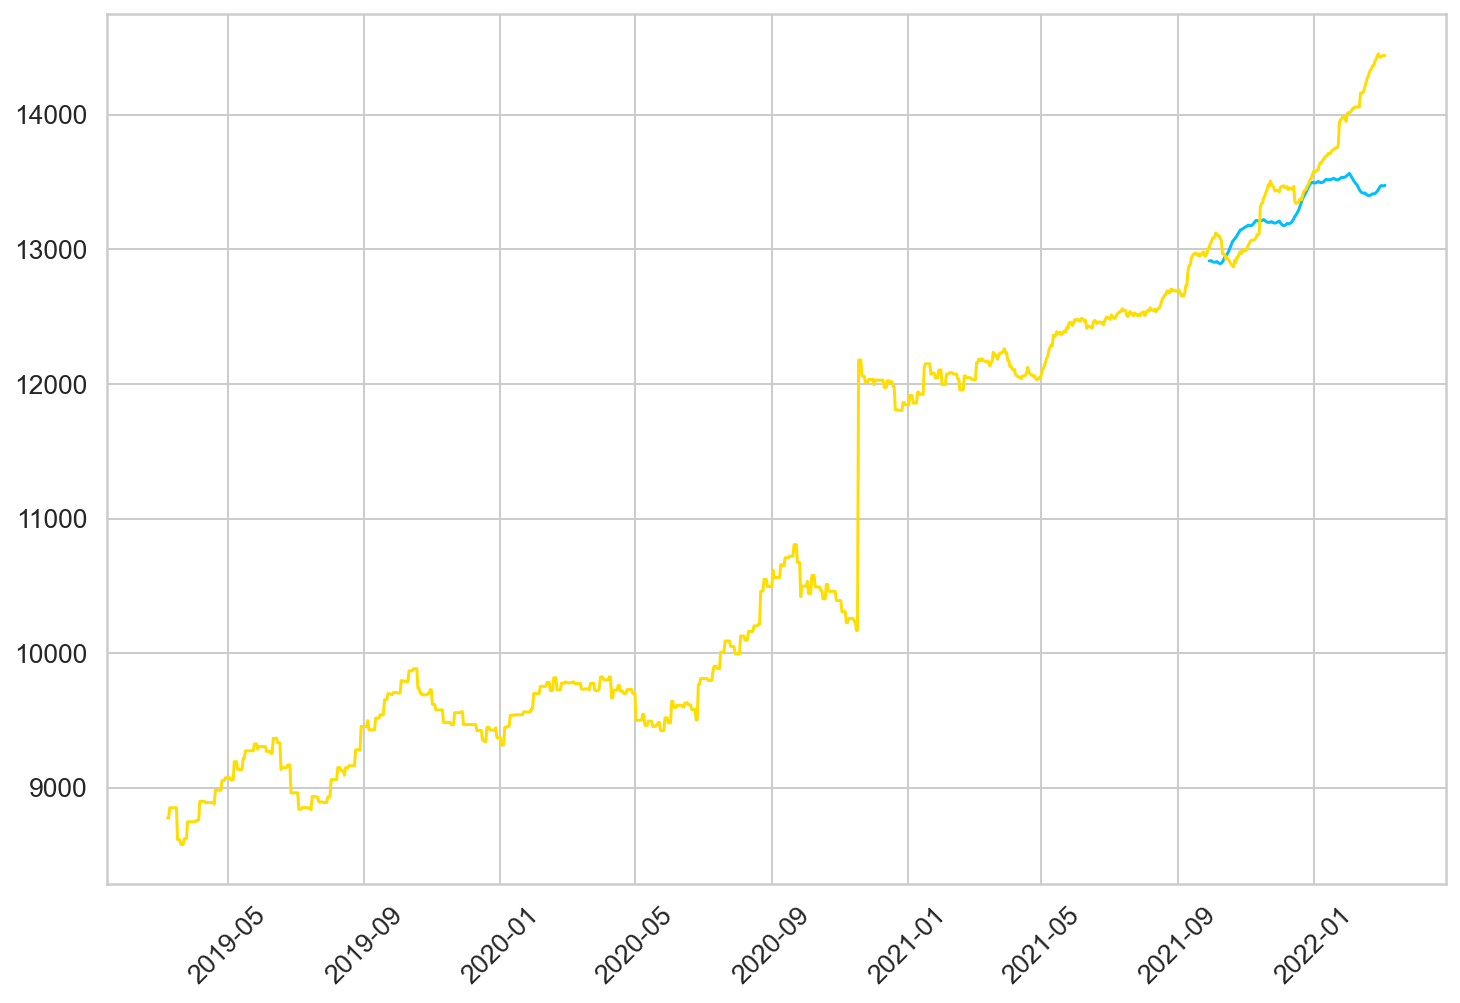

In [400]:
test_dates = matplotlib.dates.date2num(test_sequences_data.Date.tolist())
all_dates = matplotlib.dates.date2num(watch.Date.tolist())
plt.plot_date(test_dates[DAYS_PREDICTION:], predictions_descaled, '-', label='predicted')
plt.plot_date(all_dates, watch.Price.tolist(), '-', label='real')

# i = 185
# plt.plot_date([test_dates[i-SEQUENCE_LENGTH], test_dates[i], test_dates[DAYS_PREDICTION+i]], 
# [labels_descaled[i-DAYS_PREDICTION-SEQUENCE_LENGTH], labels_descaled[i-DAYS_PREDICTION], predictions_descaled[i]], '-', label='PREDICTION_1')

# i = 250
# plt.plot_date([test_dates[i-SEQUENCE_LENGTH], test_dates[i], test_dates[DAYS_PREDICTION+i]], 
# [labels_descaled[i-DAYS_PREDICTION-SEQUENCE_LENGTH], labels_descaled[i-DAYS_PREDICTION], predictions_descaled[i]], '-', label='PREDICTION_2')

# i = 620
# plt.plot_date([test_dates[i-SEQUENCE_LENGTH], test_dates[i], test_dates[DAYS_PREDICTION+i]], 
# [labels_descaled[i-DAYS_PREDICTION-SEQUENCE_LENGTH], labels_descaled[i-DAYS_PREDICTION], predictions_descaled[i]], '-', label='PREDICTION_3')

plt.xticks(rotation=45)
# plt.legend()
plt.show()

# Evalution function

In [401]:
# class prediction:
#     def __init__(self, model_path, n_features):
#         self.trained_model = PricePredictor.load_from_checkpoint(
#             model_path,
#             n_features=n_features
#         )
#         self.trained_model.freeze()

#     def get_result(self, sequence, days):
#         _, predictions = trained_model(sequence.unsqueeze(dim=0))
        


In [402]:
df = pd.DataFrame()
df['min'] = scaler.min_
df['scale'] = scaler.scale_
df.to_csv('checkpoints/scale.csv')
df.head()

,min,scale
0,-1.000000,0.333333
1,-1.066667,0.066667
2,-1.039216,0.039216
3,-1.181818,0.181818
4,0.388881,0.000290
